##### Load dataframes

In [7]:
#@markdown <b>Run me to import underscore module</b><br/>   {display-mode: "form"}
!pip install -q tensorflowjs
!pip install -q githubrelease
import numpy as np
import os, glob, re, time, json
import github_release
import tensorflow.keras.backend as K
from IPython import display
from contextlib import redirect_stdout

compressed_dirs = set()


def _compress(source_path, target_path, target_dir=None):
    if target_dir:
        !mkdir -p {target_dir}
    if target_path.endswith('.tar.gz'):
        !tar -czf {target_path} -C {source_path} .
    elif target_path.endswith('.tar'):
        !tar -cf {target_path} -C {source_path} .
    elif target_path.endswith('.zip'):
        !(cd {source_path} && zip -q -r {target_path} .)


def _extract(source_path, target_path):
    !mkdir -p {target_path}
    if source_path.endswith('.tar.gz'):
        !tar -xzf {source_path} -C {target_path}
    elif source_path.endswith('.tar'):
        !tar -xf {source_path} -C {target_path}
    elif source_path.endswith('.zip'):
        !unzip -qq {source_path} -d {target_path}


def _under(source_path, target_path, copy=True, auth_on_upload=True):
    """
    Use cases:
        Movement:
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Compression (e.g. from dir to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction (e.g. from .zip to dir):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction & compression (e.g. from .zip to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
    """
    COMPRESSION_FORMATS = ('zip', 'tar', 'tar.gz')
    TEMP_DIR = "/tmp_"
    LOG_TEMPLATE = "{}    from    {}    to    {}"

    # Source
    if source_path.endswith("/"):
        source_path = source_path[:-1]
    source_dir, _, source_name = source_path.rpartition('/')
    source_isgcs = source_path.startswith("gs://")
    source_islocal = not source_isgcs
    if source_islocal:
        source_path = os.path.abspath(source_path)
    source_isprefix, source_isfile, source_ext = source_name.partition('.')
    source_isdir = not source_isfile
    source_iscompression = source_ext in COMPRESSION_FORMATS

    # Target
    target_dir, _, target_name = target_path.rpartition('/')
    target_isgcs = target_path.startswith("gs://")
    target_islocal = not target_isgcs
    target_prefix, target_isfile, target_ext = target_name.partition('.')
    target_isdir = not target_isfile
    target_iscompression = target_ext in COMPRESSION_FORMATS

    # Flags
    MOVE_ONLY = source_ext == target_ext
    GCS_ONLY = source_isgcs and target_isgcs
    RENAME = source_isprefix != target_prefix
    COMPRESSION = source_isdir and target_iscompression
    EXTRACTION = source_iscompression and target_isdir
    EXTRACTION_COMPRESSION = source_iscompression and target_iscompression and source_ext != target_ext

    # Add forward slash if file is at root level
    source_dir = "/" if not source_dir else source_dir
    target_dir = "/" if not target_dir else target_dir

    # Authenticate if writing to GCS
    if target_isgcs and auth_on_upload:
        from google.colab import auth
        auth.authenticate_user()

    # Assert that subdirectories exist if target is local
    if target_islocal:
        !mkdir -p {target_dir}

    # Movement commands
    if MOVE_ONLY:
        # GCS -> GCS
        if source_isgcs and target_isgcs:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                !gsutil -m -q mv {source_path} {target_path}
        
        # LOCAL -> LOCAL
        elif source_islocal and target_islocal:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !cp -r {source_path} {target_path}
            else:
                !mv {source_path} {target_path}
        
        # GCS -> LOCAL
        elif source_isgcs and target_islocal:
            if source_isdir:
                print(LOG_TEMPLATE.format("DOWNLOADING DIR (1/1)", source_path, target_dir))
                !gsutil -m -q cp -r {source_path} {target_dir}
                if RENAME:
                    print(LOG_TEMPLATE.format("\tRENAMING DIR", source_isprefix, target_prefix))
                    !mv {target_dir}/{source_isprefix} {target_dir}/{target_prefix}
            else:
                print(LOG_TEMPLATE.format("DOWNLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        
        # LOCAL -> GCS
        if source_islocal and target_isgcs:
            if source_isdir:
                print(LOG_TEMPLATE.format("UPLOADING DIR (1/1)", source_path, target_path))
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                print(LOG_TEMPLATE.format("UPLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        return


    # Create directory for intermediate storage if required
    if source_isgcs or target_isgcs or EXTRACTION_COMPRESSION:
        !mkdir -p {TEMP_DIR}
    

    # For remaining operations, download GCS source to temp and treat as local
    if source_isgcs:
        if source_isdir:
            print(LOG_TEMPLATE.format("\tDOWNLOADING DIR", source_path, TEMP_DIR))
            !gsutil -m -q cp -r {source_path} {TEMP_DIR}
        else:
            print(LOG_TEMPLATE.format("\tDOWNLOADING FILE", source_path, f"{TEMP_DIR}/{source_name}"))
            !gsutil -m -q cp {source_path} {TEMP_DIR}/{source_name}
        source_path = f"{TEMP_DIR}/{source_name}"
        source_dir = TEMP_DIR

    # Compression
    if COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("COMPRESSING (1/1)", source_path, target_path))
            _compress(source_path, target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("COMPRESSING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _compress(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}

    # Extraction
    elif EXTRACTION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/1)", source_path, target_path))
            _extract(source_path, target_path)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _extract(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING DIR (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp -r {TEMP_DIR}/{target_name} {target_path}

    # Extraction & compression
    elif EXTRACTION_COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/2)", f"{TEMP_DIR}/{target_prefix}", target_path))
            _compress(f"{TEMP_DIR}/{target_prefix}", target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/3)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/3)", f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}"))
            _compress(f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (3/3)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}
    
    # Cleanup intermediate storage
    !rm -rf {TEMP_DIR}

def _set_gh_token(token):
    os.environ["GITHUB_TOKEN"] = token


def _export_array(array, release_name, prefix="", splits=3):
    dir_path = f"/tmp_/{release_name}"
    !mkdir -p {dir_path}
    n_digits = len(str(splits - 1))
    subarrays = np.array_split(array, splits)
    for i, subarray in enumerate(subarrays):
        filename = f"{prefix}__{str(i).zfill(n_digits)}.npy"
        np.save(f"{dir_path}/{filename}", subarray)


def _concat_arrays(paths):
    return np.concatenate([np.load(path, allow_pickle=True) for path in sorted(paths)])


def _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs):
    # Assert that GitHub Auth token is set
    if "GITHUB_TOKEN" not in os.environ:
        print("GitHub authentication token is not set.")
        print("Set token using the '_set_gh_token(token_string)' method.")
        print("Minimal required auth scope is 'repo/public_repo' for public repositories.")
        print("URL: https://github.com/settings/tokens/new")
        return

    # Split arrays
    for prefix, array in arr_kwargs.items():
        splits = int((array.nbytes/1_000_000) // split_size) + 1
        _export_array(array, release_name, prefix=prefix, splits=splits)

    # Upload arrays
    github_release.gh_release_create(
        f"{user_name}/{repo_name}", 
        release_name, 
        publish=True, 
        name=release_name, 
        asset_pattern=f"/tmp_/{release_name}/*"
    )
    !rm -rf /tmp_/*


def _from_gh(user_name, repo_name, release_name):
    # Download release to temporary directory
    print("Downloading dataset in parallell ... ", end='\t')
    t0 = time.perf_counter()
    assets = github_release.get_assets(f"{user_name}/{repo_name}", tag_name=release_name)
    download_urls = [asset['browser_download_url'] for asset in assets]
    urls_str = " ".join(download_urls)
    !echo {urls_str} | xargs -n 1 -P 8 wget -q -P /tmp_/{release_name}_dl/
    t1 = time.perf_counter()
    print(f"done! ({t1 - t0:.3f} seconds)")

    # Load data into numpy arrays
    paths = glob.glob(f"/tmp_/{release_name}_dl/*.npy")
    groups = {}
    for path in paths:
        match = re.match(r".*/(.*)__[0-9]*\.npy", path)
        if match:
            prefix = match.group(1)
            groups[prefix] = groups.get(prefix, []) + [path]
    arrays_dict = {name: _concat_arrays(paths) for name, paths in groups.items()}
    !rm -rf /tmp_/*
    return arrays_dict
    

def _log_to_gh(user, repo, tag, log_dir="/tmp/logs"):
    # Create temporary directory for compressed logs
    !mkdir -p /tmp/compressed_logs
    
    # Compress all directories in log dir
    for dirname in os.listdir(log_dir):
        # Skip files
        if "." in dirname or dirname in compressed_dirs:
            continue

        # Compress
        _under(f"{log_dir}/{dirname}", f"/tmp/compressed_logs/{dirname}.tar.gz")
        compressed_dirs.add(dirname)

    # Upload compressed logs to GitHub
    github_release.gh_asset_upload(f"{user}/{repo}", tag, f"/tmp/compressed_logs/*.tar.gz")

    # Cleanup compressed logs
    !rm -rf /tmp/compressed_logs/*

def timeit(method):
    def timed(*args, **kw):
        ts = time.perf_counter()
        result = method(*args, **kw)
        te = time.perf_counter()
        diff = te - ts
        print(f"{method.__name__}: {diff:.8f} s")
        return result
    return timed

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

@timeit
def _export_model(model, model_name, model_type, val_dataset, test_dataset, params, hparams, history, log_dir, n_prep_layers=None):
    # Create temporary directory
    target_dir = f"/tmp/models/{model_type}/{model_name}"
    !mkdir -p {target_dir}     #/tmp_/models/rnn_naive/rnn_naive_20201108_130308

    # Write export logs to file
    export_logs_path = os.path.join(target_dir, "export_logs.txt")
    with open(export_logs_path, 'w') as export_logs:
        with redirect_stdout(export_logs):
            # Profile model on inputs (average of n_runs cycles)
            n_runs = 5
            input_shape = val_dataset.element_spec[0].shape

            def time_examples(model, n):
                dummy = np.random.rand(n, *input_shape[1:])
                t0 = time.perf_counter()
                model.predict(dummy)
                return time.perf_counter() - t0

            with tf.device('/CPU:0'):
                cpu_profiles = {
                    "cpu_1": np.array([time_examples(model, 1) for _ in range(n_runs)]).mean(),
                    "cpu_10": np.array([time_examples(model, 10) for _ in range(n_runs)]).mean(),
                    "cpu_100": np.array([time_examples(model, 100) for _ in range(n_runs)]).mean()
                }

            with tf.device('/GPU:0'):
                gpu_profiles = {
                    "gpu_1": np.array([time_examples(model, 1) for _ in range(n_runs)]).mean(),
                    "gpu_10": np.array([time_examples(model, 10) for _ in range(n_runs)]).mean(),
                    "gpu_100": np.array([time_examples(model, 100) for _ in range(n_runs)]).mean()
                }

            # Get number of parameters
            params_counts = {
                "trainable_params": np.sum([K.count_params(w) for w in model.trainable_weights]),
                "non_trainable_params": np.sum([K.count_params(w) for w in model.non_trainable_weights])
            }
            params_counts["total_params"] = params_counts["trainable_params"] + params_counts["non_trainable_params"]

            # Generate evaluation metrics for validation and test set
            final_metrics_val = model.evaluate(val_dataset, return_dict=True)
            final_metrics_val = {f"final_val_{k}": v for k, v in final_metrics_val.items()}
            final_metrics_test = model.evaluate(test_dataset, return_dict=True)
            final_metrics_test = {f"final_test_{k}": v for k, v in final_metrics_test.items()}

            # Generate Dataframe and export to parquet
            logs_params = {
                **params,
                **hparams,
                **history.params,
                **cpu_profiles,
                **gpu_profiles,
                **params_counts,
                **final_metrics_val,
                **final_metrics_test
            }
            logs_df = pd.DataFrame({**history.history, "epoch": history.epoch})
            for param, value in logs_params.items():
                logs_df[param] = value
            logs_df.to_parquet(os.path.join(target_dir, "logs.parquet"))

            # Dump all parameters and metadata to .json file
            with open(os.path.join(target_dir, 'model_details.json'), 'w') as f:
                json.dump(logs_params, f, cls=NpEncoder, indent=4)

            def _convert_model(model, subdir="model"):
                # Create subdirectory
                subdir_path = os.path.join(target_dir, subdir)
                !mkdir -p {subdir_path}

                # Write model summary to file
                model_summary_path = os.path.join(subdir_path, "model_summary.txt")
                with open(model_summary_path, 'w') as model_summary:
                    with redirect_stdout(model_summary):
                        model.summary()

                # Export model summary as image
                model_summary_img_path = os.path.join(subdir_path, "model_summary.png")
                tf.keras.utils.plot_model(model, to_file=model_summary_img_path, show_shapes=True)

                # Generate model paths
                keras_model_path = os.path.join(subdir_path, "keras_model.h5")
                saved_model_path = os.path.join(subdir_path, "saved_model")
                tfjs_layers_model_path = os.path.join(subdir_path, "tfjs_layers_model")
                tfjs_graph_model_path = os.path.join(subdir_path, "tfjs_graph_model")

                # Save and convert model
                model.save(keras_model_path)
                tf.saved_model.save(model, saved_model_path)
                !tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model {keras_model_path} {tfjs_layers_model_path}
                !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_path} {tfjs_graph_model_path}
            
            # Convert full model
            _convert_model(model, subdir="model")

            if n_prep_layers is not None:
                model_1 = tf.keras.Sequential(model.layers[:n_prep_layers])
                model_1.build(input_shape=input_shape)
                
                model_2 = tf.keras.Sequential(model.layers[n_prep_layers:])
                model_2.build(input_shape=model_1.layers[-1].output_shape)

                # Convert models
                _convert_model(model_1, subdir="submodel_1")
                _convert_model(model_2, subdir="submodel_2")

            # Compress TensorBoard logs
            model_log_dir = os.path.join(LOG_DIR, model_name)
            tensorboard_logs_path = os.path.join(target_dir, "tensorboard.tar.gz")
            _under(model_log_dir, tensorboard_logs_path)

    # Upload logs to GCS
    _under(target_dir, f"gs://marvin-voice/models/{model_type}/{model_name}", auth_on_upload=False)
    return logs_df

display.clear_output(wait=False)


In [8]:
#@markdown <b>Load all dataframes into dataframes</b><br/>   {display-mode: "form"}
#@markdown <small>Dataframes:</small><br/> 
#@markdown <small><small>&nbsp; &nbsp; &nbsp; <b>rnn_df:</B> &nbsp; &nbsp; Contains log data for every epoch </small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; <b>rnn_df_unique:</B> &nbsp; &nbsp; Contains one row per run </small></small><br/>
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def logs_to_df(model_type):
    # Download .parquet files
    target_dir = f"/tmp/df_files/{model_type}"
    !mkdir -p {target_dir}
    !gsutil -m cp gs://telenor-data-science/models/{model_type}/**/*.parquet {target_dir}

    # Load all .parquet files as dataframes
    dfs = []
    for path in glob.glob(f"{target_dir}/**/*.parquet", recursive=True):
        df = pd.read_parquet(path)
        model_name = path.split(os.sep)[-1].split('.')[0]
        df['model_name'] = model_name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

rnn_df = logs_to_df("rnn_updated")
rnn_df_unique = rnn_df[rnn_df.epoch == 1]
display.clear_output(wait=False)

##### Analyze

In [9]:
#@title List data for all runs { display-mode: "form" }
df = rnn_df_unique
df = df[df["output_sequence_len"] == 48]
#print(df.groupby("output_sequence_len"))
#print(df.shape)
df.sort_values('final_val_mse')

,loss,mse,mae,msle,val_loss,val_mse,val_mae,val_msle,epoch,num_epochs,dataset,train_split,val_split,test_split,recurrent_layers,recurrent_units,input_sequence_len,batch_size,optimizer,learning_rate,recurrent_cell,output_sequence_len,__timestamp__,verbose,epochs,steps,trainable_params,non_trainable_params,total_params,final_train_loss,final_train_mse,final_train_mae,final_train_msle,final_val_loss,final_val_mse,final_val_mae,final_val_msle,final_test_loss,final_test_mse,final_test_mae,final_test_msle,baseline_train_loss,baseline_train_mse,baseline_train_mae,baseline_train_msle,baseline_val_loss,baseline_val_mse,baseline_val_mae,baseline_val_msle,baseline_test_loss,baseline_test_mse,baseline_test_mae,baseline_test_msle,model_name
1313,mse,0.999147,0.590957,0.153624,0.690092,0.690092,0.512554,0.076961,1,45,NaN,0.5,0.25,0.25,3,16,12,128,rmsprop,0.000032,lstm,48,20201112063542,0,300,137,7536,0.0,7536.0,0.896547,0.896547,0.494455,0.132667,0.624347,0.624347,0.408644,0.074099,0.434981,0.434981,0.338510,0.046628,1.208499,0.951241,0.466510,0.120575,1.045602,1.045602,0.433237,0.119657,0.665119,0.665119,0.293539,0.071197,rnn_updated_20201112_063542
228,mae,1.002700,0.582287,0.156237,0.491220,0.681530,0.491220,0.077822,1,28,NaN,0.5,0.25,0.25,3,16,12,32,adam,0.000032,lstm,48,20201112052157,0,300,547,7536,0.0,7536.0,0.472011,0.988127,0.472011,0.156994,0.371689,0.635312,0.371689,0.077686,0.289369,0.434599,0.289369,0.047790,0.530294,0.951114,0.450167,0.120961,0.433237,1.045602,0.433237,0.119657,0.293539,0.665118,0.293539,0.071197,rnn_updated_20201112_052157
4823,mae,0.979326,0.497048,0.157792,0.329519,0.645187,0.329519,0.078804,1,23,NaN,0.5,0.25,0.25,4,16,24,128,adam,0.000316,lstm,48,20201112053753,0,300,137,9648,0.0,9648.0,0.459573,0.988658,0.459573,0.156046,0.322873,0.646582,0.322873,0.078610,0.252132,0.447910,0.252132,0.048011,0.530516,0.956178,0.437973,0.121123,0.433751,1.047036,0.433751,0.119823,0.293748,0.665983,0.293748,0.071295,rnn_updated_20201112_053753
2928,mae,0.978384,0.550055,0.149794,0.458839,0.666448,0.458839,0.077167,1,24,NaN,0.5,0.25,0.25,2,32,48,256,adam,0.000316,lstm,48,20201112060450,0,300,69,16944,0.0,16944.0,0.444294,0.921103,0.444294,0.139630,0.413506,0.654878,0.413506,0.075867,0.338788,0.449601,0.338788,0.046897,0.530896,0.957990,0.467093,0.120928,0.434743,1.049910,0.434743,0.120154,0.294142,0.667692,0.294142,0.071489,rnn_updated_20201112_060450
644,mae,1.011975,0.592000,0.151615,0.523481,0.709857,0.523481,0.078418,1,44,NaN,0.5,0.25,0.25,2,32,12,128,rmsprop,0.000032,lstm,48,20201112060625,0,300,137,16944,0.0,16944.0,0.451484,0.912994,0.451484,0.139980,0.430196,0.663072,0.430196,0.077221,0.339625,0.456694,0.339625,0.047349,0.530293,0.958462,0.466880,0.120815,0.433237,1.045602,0.433237,0.119657,0.293539,0.665119,0.293539,0.071197,rnn_updated_20201112_060625
4846,mse,1.002416,0.593194,0.151837,0.699171,0.699171,0.519149,0.076732,1,123,NaN,0.5,0.25,0.25,3,64,12,64,sgd,0.000316,lstm,48,20201112054312,0,300,274,91440,0.0,91440.0,0.888981,0.888981,0.526990,0.123028,0.675124,0.675124,0.498907,0.076705,0.480026,0.480026,0.424641,0.046465,1.208498,0.966221,0.495156,0.120521,1.045602,1.045602,0.433237,0.119657,0.665119,0.665119,0.293539,0.071197,rnn_updated_20201112_054312
594,mse,0.990731,0.581105,0.149541,0.703452,0.703452,0.528842,0.075967,1,25,NaN,0.5,0.25,0.25,2,16,12,256,rmsprop,0.000316,lstm,48,20201112055727,0,300,69,5424,0.0,5424.0,0.897598,0.897598,0.514893,0.128565,0.680373,0.680373,0.504034,0.076312,0.506305,0.506305,0.448685,0.047508,1.208499,0.974962,0.503152,0.120868,1.045602,1.045602,0.433237,0.119657,0.665119,0.665119,0.293539,0.071197,rnn_updated_20201112_055727
2881,mse,1.007711,0.594937,0.148414,0.708634,0.708634,0.522998,0.077836,1,47,NaN,0.5,0.25,0.25,2,128,12,32,sgd,0.000316,lstm,48,20201112051317,1,1000,547,215088,0.0,215088.0,0.889496,0.889496,0.534244,0.122255,0.682735,0.682735,0.509986,0.076648,0.493101,0.493101,0.437995,0.047378,1.208499,0.970571,0.499597,0.120824,1.045602,1.045602,0.433237,0.119657,0.

In [10]:
#@title List selected columns for all runs { display-mode: "form" }
columns = [
    "model_name", "num_epochs", "input_sequence_len", "output_sequence_len", "loss", "optimizer", "learning_rate",
    "recurrent_layers", "recurrent_units",
    "final_train_loss", "baseline_train_loss", 
    "final_val_loss", "baseline_val_loss",
    "final_test_loss", "baseline_test_loss", 
]
df = rnn_df_unique[columns]
df = df[df["loss"] == 'mse']
# df = df[df["optimizer"] == 'sgd']input_sequence_len
df = df[df["input_sequence_len"] == 168]
# df = df[df["output_sequence_len"] == 24]
# df = df[df["num_epochs"] >= 50]
df.sort_values('final_val_loss')

,model_name,num_epochs,input_sequence_len,output_sequence_len,loss,optimizer,learning_rate,recurrent_layers,recurrent_units,final_train_loss,baseline_train_loss,final_val_loss,baseline_val_loss,final_test_loss,baseline_test_loss
3009,rnn_updated_20201112_140722,19,168,12,mse,adam,0.001,3,64,0.543025,0.914664,0.484428,0.721603,0.347668,0.433818
5357,rnn_updated_20201112_141734,18,168,12,mse,adam,0.001,3,64,0.584781,0.914664,0.514719,0.721603,0.350959,0.433818
989,rnn_updated_20201112_145300,24,168,12,mse,adam,0.001,3,64,0.428243,0.914664,0.520013,0.721603,0.357039,0.433818
3759,rnn_updated_20201112_135708,19,168,12,mse,adam,0.001,3,64,0.586172,0.914664,0.521030,0.721603,0.415696,0.433818
3744,rnn_updated_20201112_144444,15,168,12,mse,adam,0.001,3,64,0.666037,0.914664,0.531170,0.721603,0.377152,0.433818
5375,rnn_updated_20201112_143530,17,168,12,mse,adam,0.001,3,64,0.604063,0.914664,0.534806,0.721603,0.362286,0.433818
3778,rnn_updated_20201112_134823,16,168,12,mse,adam,0.001,3,64,0.629786,0.914664,0.542974,0.721603,0.358915,0.433818
3408,rnn_updated_20201112_142715,15,168,12,mse,adam,0.001,3,64,0.601096,0.914664,0.550994,0.721603,0.387210,0.433818
37,rnn_updated_20201112_150952,13,168,24,mse,adam,0.001,3,64,0.791101,1.050047,0.580392,0.916076,0.403735,0.568749
688,rnn_updated_20201112_154112,19,168,24,mse,adam,0.001,3,64,0.662998,1.171861,0.644441,1.088479,0.416104,0.635078


##### Plots and tables

In [11]:
#@markdown <b>Single model metrics table</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
columns = [
    "model_name", "num_epochs", "input_sequence_len", "output_sequence_len", "loss", "optimizer", "learning_rate",
    "recurrent_layers", "recurrent_units",
    "final_train_mse", "baseline_train_mse", 
    "final_val_mse", "baseline_val_mse",
    "final_test_mse", "baseline_test_mse", 
    "final_train_mae", "baseline_train_mae", 
    "final_val_mae", "baseline_val_mae",
    "final_test_mae", "baseline_test_mae", 
]
df = rnn_df_unique
df = df[df["output_sequence_len"] == 48]
df = df[columns]
df.sort_values("final_val_mse")
df[df["model_name"] == 'rnn_updated_20201112_181207'].T

,78
model_name,rnn_updated_20201112_181207
num_epochs,150
input_sequence_len,48
output_sequence_len,48
loss,mse
optimizer,adam
learning_rate,3.16228e-05
recurrent_layers,3
recurrent_units,64
final_train_mse,0.696137


In [ ]:
#@markdown <b>Deprecated metrics table</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
columns = [
    "input_sequence_len", "output_sequence_len", "loss",
    "final_train_mse", "baseline_train_mse", 
    "final_val_mse", "baseline_val_mse",
    "final_test_mse", "baseline_test_mse", 
    "final_train_msle", "baseline_train_msle", 
    "final_val_msle", "baseline_val_msle",
    "final_test_msle", "baseline_test_msle", 
]

plot_df = pd.DataFrame({
    'loss': ['MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MAE', 'MAE', 'MAE', 'MAE', 'MAE', 'MAE'][:6],
    'model': ['LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline"][:6],
    'split': ['train', 'train', 'val', 'val', 'test', 'test', 'train', 'train', 'val', 'val', 'test', 'test'][:6],
    'value': [0.696137, 0.08993, 0.717672, 0.24772, 0.558553, 0.755401, 0.478236, 0.54774, 0.45918, 0.531971, 0.380603, 0.350519][:6]
}) 

df = rnn_df_unique
df = df[(df["model_name"] == 'rnn_updated_20201112_181207') | (df["model_name"] == 'rnn_updated_20201112_045113')]
df = df[columns]
df.T

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


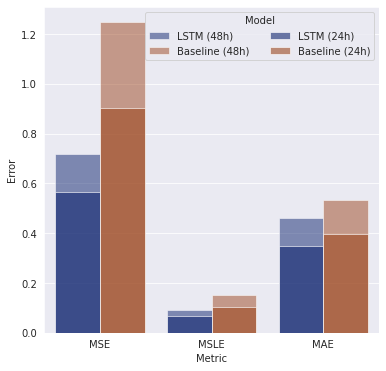

In [52]:
#@markdown <b>Generate metrics table</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
columns = [
    "model_name", "input_sequence_len", "output_sequence_len",
    "final_train_mse", "baseline_train_mse", 
    "final_val_mse", "baseline_val_mse",
    "final_test_mse", "baseline_test_mse", 
    "final_train_msle", "baseline_train_msle", 
    "final_val_msle", "baseline_val_msle",
    "final_test_msle", "baseline_test_msle", 
    "final_train_mae", "baseline_train_mae", 
    "final_val_mae", "baseline_val_mae",
    "final_test_mae", "baseline_test_mae", 
]
two_dfs = rnn_df_unique
two_dfs = two_dfs[columns]
full_df = pd.DataFrame()
for model_name in ('rnn_updated_20201112_181207', 'rnn_updated_20201112_045113'):
    df = two_dfs[(two_dfs["model_name"] == model_name)]
    base_df = df[["model_name", "input_sequence_len", "output_sequence_len"]].to_dict(orient='record')[0]
    for tups in df.drop(["model_name", "input_sequence_len", "output_sequence_len"], axis=1).T.itertuples():
        new_base_df = base_df.copy()
        tups_dict = tups._asdict()
        col = tups_dict['Index']
        value = tups_dict['_1']
        kind, split, loss = col.split('_')
        base_df["kind"] = kind
        base_df["split"] = split
        base_df["loss"] = loss
        base_df["value"] = value
        full_df = full_df.append(base_df, ignore_index=True)
full_df = full_df.replace('final', 'LSTM')
full_df = full_df.replace('baseline', 'Baseline')
full_df['loss'] = full_df['loss'].str.upper()
full_df["model"] = full_df["kind"] + " (" + full_df["output_sequence_len"].astype(int).astype(str) + "h)"
full_df = full_df[(full_df["split"] == 'val') | (full_df["split"] == 'test')]


####################################################################
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))
# sns.catplot(
#     data=full_df[(full_df["kind"] == "Baseline")], kind="bar",  col="split", 
#     x="loss", y="value", hue="model",
#     palette="dark", alpha=.6, height=4, ci=None
# )
full_df = full_df[(full_df["split"] == 'val')]

sns.set_style("darkgrid")

sns.barplot(
    data=full_df[(full_df["output_sequence_len"] == 48)],
    x="loss", y="value", hue="model",
    palette="dark", alpha=.5, ci=None
)
sns.barplot(
    data=full_df[(full_df["output_sequence_len"] == 24)],
    x="loss", y="value", hue="model",
    palette="dark", alpha=.6, ci=None
)
# fig.suptitle("Evaluation metrics for LSTM model vs. naive forecasting")
ax.legend(ncol=2, loc="upper right", frameon=True, title="Model")
ax.set(ylabel="Error", xlabel="Metric")
fig.savefig("lstm_evaluation_metrics_val.png", transparent=False)
#####################################################################

full_df = full_df.pivot_table(values='value', index=["split", "model"], columns=['loss'], aggfunc=np.sum)
full_df.to_latex("metrics_table.tex", 
            multirow=True, 
            caption="Evaluation metrics for the two models.", 
            float_format=lambda x: f"{x:.3f}" if np.mod(x, 1) else f"{int(x)}",
            bold_rows=True)


In [ ]:
#@markdown <b>Relevant columns for all runs</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
columns = [
    "model_name", "input_sequence_len", "output_sequence_len",
    "final_train_mse", "baseline_train_mse", 
    "final_val_mse", "baseline_val_mse",
    "final_test_mse", "baseline_test_mse", 
    "final_train_msle", "baseline_train_msle", 
    "final_val_msle", "baseline_val_msle",
    "final_test_msle", "baseline_test_msle", 
]
cols_df = rnn_df_unique
cols_df = cols_df[columns]
cols_df

In [ ]:
#@markdown <b>Old metrics plot ...</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
import seaborn as sns
sns.set_theme(style="whitegrid")

#penguins = sns.load_dataset("penguins")

plot_df = pd.DataFrame({
    'loss': ['MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 
             'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE', 'MSLE'],
    'model': ['LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 
              'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline", 'LSTM', "Baseline"],
    'window': ["48"]*12 + ["24"]*12,
    'split': ['train', 'train', 'val', 'val', 'test', 'test', 'train', 'train', 'val', 'val', 'test', 'test', 
              'train', 'train', 'val', 'val', 'test', 'test', 'train', 'train', 'val', 'val', 'test', 'test'],
    'value': [0.696137, 0.08993, 0.717672, 0.24772, 0.558553, 0.755401, 0.101187, 0.149766, 0.0920841, 0.150722, 0.0748035, 0.0833627, 
              0.734569, 0.823731, 0.565556, 0.903778, 0.383143, 0.561294, 0.103062, 0.104344, 0.0691693, 0.104846, 0.0433416, 0.0608636]
}) 
plot_df["grouped"] = plot_df["loss"] + " (" + plot_df["split"] + ")"
plot_df["grouped_model"] = plot_df["model"] + " (" + plot_df["window"] + " hour prediction)"

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=plot_df, kind="bar",
    x="split", y="value", hue="grouped_model",
    palette="dark", alpha=.6, height=4,
)
g.fig.suptitle("Evaluation metrics for LSTM model vs. naive forecasting")
g.despine(left=True)
g.set_axis_labels("Dataset split", "Mean Squared Error")
g.legend.set_title("")
g.savefig("lstm_evaluation_metrics.png")

In [ ]:
#@markdown <b>Plot training progress for selected runs</b><br/> { vertical-output: true, output-height: 100, display-mode: "form" }
sns.set(rc={'figure.figsize':(8,5)})
p_df = rnn_df
# p_df = p_df[p_df["input_sequence_len"] == 168]
# p_df = p_df[p_df["output_sequence_len"] == 12]
# p_df = p_df[p_df.optimizer == 'sgd']
p_df = p_df[p_df.model_name == 'rnn_updated_20201112_181207']
grid = sns.lineplot(data=p_df, x="epoch", y="val_mse", hue="model_name")

grid.set(ylim=(None, None));